In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#setup
import os, sys
current_path = os.path.abspath('')
parent_path = os.path.dirname(current_path)
source_path = f'{parent_path}\\src'
if not source_path in sys.path: sys.path.append(source_path)

#customs
# from data_model import *
# from data_helper import *
from config import *
setup()

F:\AppSSD\WorkTools\Anaconda\envs\gpu-ML\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
F:\AppSSD\WorkTools\Anaconda\envs\gpu-ML\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
F:\AppSSD\WorkTools\Anaconda\envs\gpu-ML\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


Config finished!


In [2]:
in_names = ['X_train', 'X_val', 'y_train', 'y_val']
X_train, X_val, y_train, y_val = [pd.read_csv(f'./data/{name}.csv', index_col = 'Date', parse_dates=True) for name in in_names]

def reshape_input(X):
    return X.values.reshape(X.shape[0], X.shape[-1], 1)

X_train, X_val = [reshape_input(X) for X in [X_train, X_val]]

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
def evaluate(model, X_val, y_val):
    y_val = y_val.reshape(y_val.shape[0], y_val.shape[1]) if len(y_val.shape) > 2 else y_val
    pred = model.predict(X_val)
    pred = pred.reshape(pred.shape[0], pred.shape[1]) if len(pred.shape) > 2 else pred

    mse = mean_squared_error(pred, y_val)
    mape = mean_absolute_percentage_error(pred, y_val)
    print('Result - MSE: ', mse, ' - MAPE: ', mape)

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [22]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10270005553944318567,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5077532672
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14283259662533308084
 physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"]

# SEED

In [6]:
from random import randint
seed_num = randint(0,10000)
seed_num = 8038
from numpy.random import seed
seed(seed_num)
tf.random.set_seed(seed_num)
print('The seed is: ', seed_num)

The seed is:  8038


# Vanilla Simple RNN

In [7]:
# basic rnn
batch_size = 32
n_output = y_train.shape[-1]
n_timestep = X_train.shape[1]
n_features = 1
input_shape = (n_timestep, n_features)

model = keras.Sequential(
    [
        layers.SimpleRNN(200, activation='relu', input_shape= input_shape),
        layers.Dense(100, activation='relu'),
        layers.Dense(n_output),
    ]
)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 200)               40400     
_________________________________________________________________
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 61,005
Trainable params: 61,005
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.fit(X_train, y_train, batch_size = batch_size)

Train on 1719 samples
1719/1719 [==============================] - ETA: 0s - loss: 1808.72 - 3s 2ms/sample - loss: 1732.2764


In [9]:
evaluate(model, X_train, y_train)
evaluate(model, X_val, y_val)

Result - MSE:  359.2128780445586  - MAPE:  0.21603347115082663
Result - MSE:  529.9260161329164  - MAPE:  2.4277646836982596


In [10]:
def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

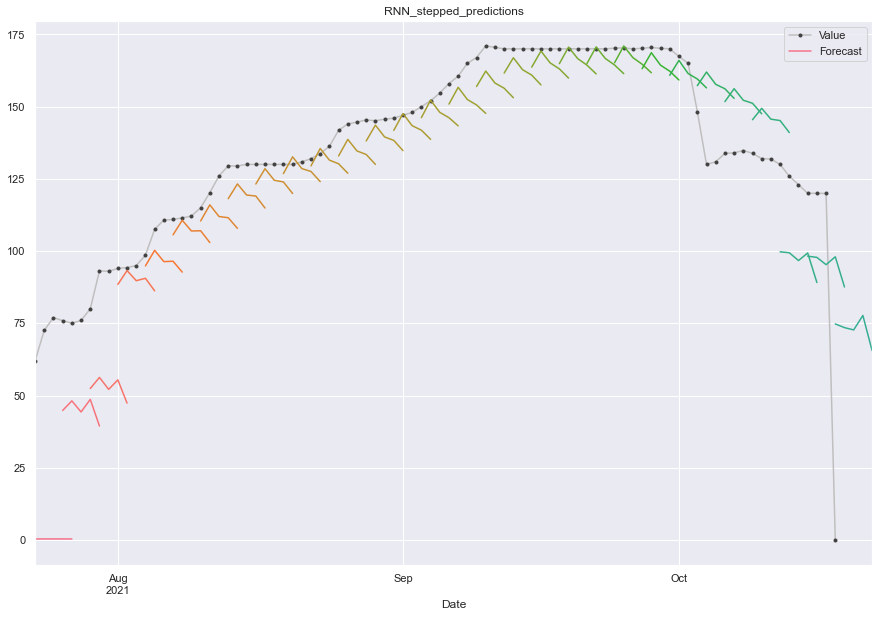

In [11]:
output_path = './output'
DPI_OUTPUT = 300

def plot_stepped_predictions(model, X_val, y_val, name, prediction_step = 3):
    pred = pd.DataFrame(
        model.predict(X_val),
        index = y_val.index, columns = y_val.columns
    )
    palette = dict(palette='husl', n_colors=64)
    ax2 = y_val['y_step_1'].plot(**plot_params)
    ax2 = plot_multistep(pred, ax=ax2, palette_kwargs=palette, every=prediction_step)
    _ = ax2.legend(['Value', 'Forecast'])

    plot_name = f'{name}_stepped_predictions'
    plt.title(plot_name)
    plt.savefig(f'{output_path}/{plot_name}.png', dpi = DPI_OUTPUT)
    plt.show()

plot_stepped_predictions(model, X_val, y_val, 'RNN')

# Vanilla LSTM

In [12]:
model = keras.Sequential(
    [
        layers.LSTM(200, activation='relu', input_shape= input_shape),
        layers.Dense(100, activation='relu'),
        layers.Dense(n_output),
    ]
)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 505       
Total params: 182,205
Trainable params: 182,205
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.fit(X_train, y_train, batch_size = batch_size)
evaluate(model, X_train, y_train)
evaluate(model, X_val, y_val)

Train on 1719 samples
1719/1719 [==============================] - 4s 2ms/sample - loss: 986.6491
Result - MSE:  213.7272108840553  - MAPE:  0.5609432917272069
Result - MSE:  494.9706530364534  - MAPE:  10.608474134082993


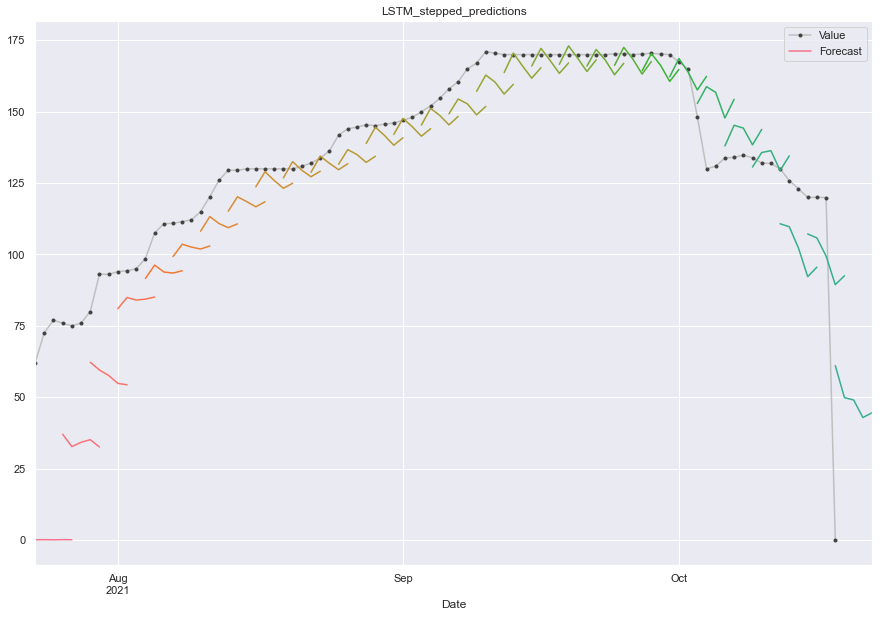

In [14]:
plot_stepped_predictions(model, X_val, y_val, 'LSTM')

# EncDec LSTM

In [15]:
# basic rnn
model = keras.Sequential(
    [
        layers.LSTM(200, activation='relu', input_shape=input_shape),
        layers.RepeatVector(n_output),
        layers.LSTM(200, activation='relu', return_sequences=True),
        layers.TimeDistributed(layers.Dense(100, activation='relu')),
        layers.TimeDistributed(layers.Dense(1)),
    ]
)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               161600    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 200)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 200)            320800    
_________________________________________________________________
time_distributed (TimeDistri (None, 5, 100)            20100     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 1)              101       
Total params: 502,601
Trainable params: 502,601
Non-trainable params: 0
_________________________________________________________________


In [16]:
special_y_train = reshape_input(y_train)
special_y_val = reshape_input(y_val)

In [17]:
model.fit(X_train, special_y_train, batch_size = batch_size)
evaluate(model, X_train, special_y_train)
evaluate(model, X_val, special_y_val)

Train on 1719 samples
1719/1719 [==============================] - 6s 4ms/sample - loss: 1306.9663
Result - MSE:  228.11734486600363  - MAPE:  0.28687565089715966
Result - MSE:  482.6882200915693  - MAPE:  4.495521934031617


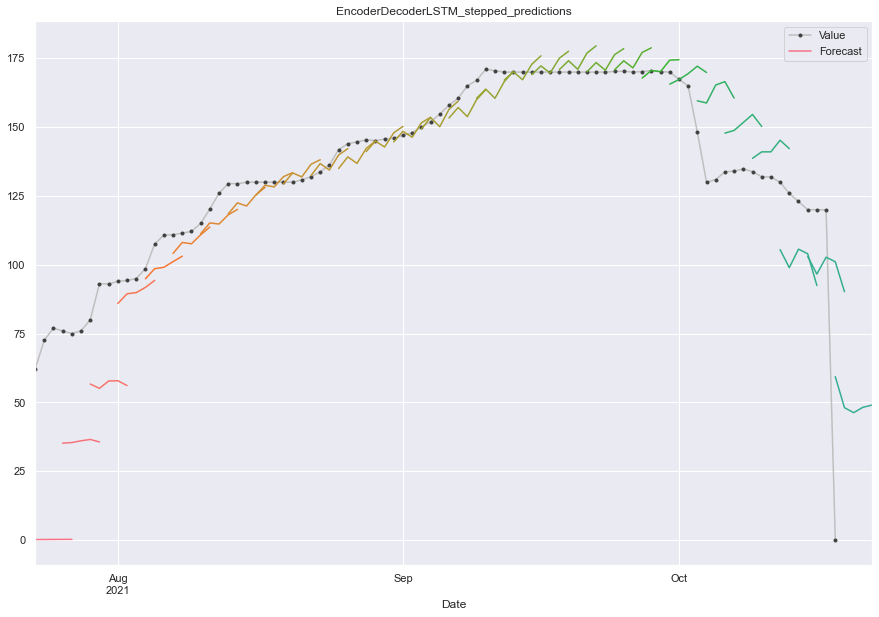

In [18]:
pred = model.predict(X_val)
pred = pred.reshape(pred.shape[0], pred.shape[1])
pred = pd.DataFrame(
    pred,
    index = y_val.index, columns = y_val.columns
)
palette = dict(palette='husl', n_colors=64)
ax2 = y_val['y_step_1'].plot(**plot_params)
ax2 = plot_multistep(pred, ax=ax2, palette_kwargs=palette, every=3)
_ = ax2.legend(['Value', 'Forecast'])

name = 'EncoderDecoderLSTM'
plot_name = f'{name}_stepped_predictions'
plt.title(plot_name)
plt.savefig(f'{output_path}/{plot_name}.png', dpi = DPI_OUTPUT)
plt.show()

# Stacked 
https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction

In [19]:
model = keras.Sequential(
    [
        layers.LSTM(100, return_sequences=True, input_shape=input_shape),
        layers.Dropout(rate=0.2),
        layers.LSTM(100, return_sequences=True),
        layers.LSTM(100, return_sequences=False),
        layers.Dropout(rate=0.2),
        layers.Dense(n_output)
    ]
)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 16, 100)           40800     
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 16, 100)           80400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 505       
Total params: 202,105
Trainable params: 202,105
Non-trainable params: 0
________________________________________________

In [20]:
model.fit(X_train, y_train, batch_size = batch_size)
evaluate(model, X_train, y_train)
evaluate(model, X_val, y_val)

Train on 1719 samples
1719/1719 [==============================] - 8s 4ms/sample - loss: 12964.6112
Result - MSE:  12101.909945071115  - MAPE:  10.72318409652018
Result - MSE:  16513.878259343805  - MAPE:  13.010073849359111


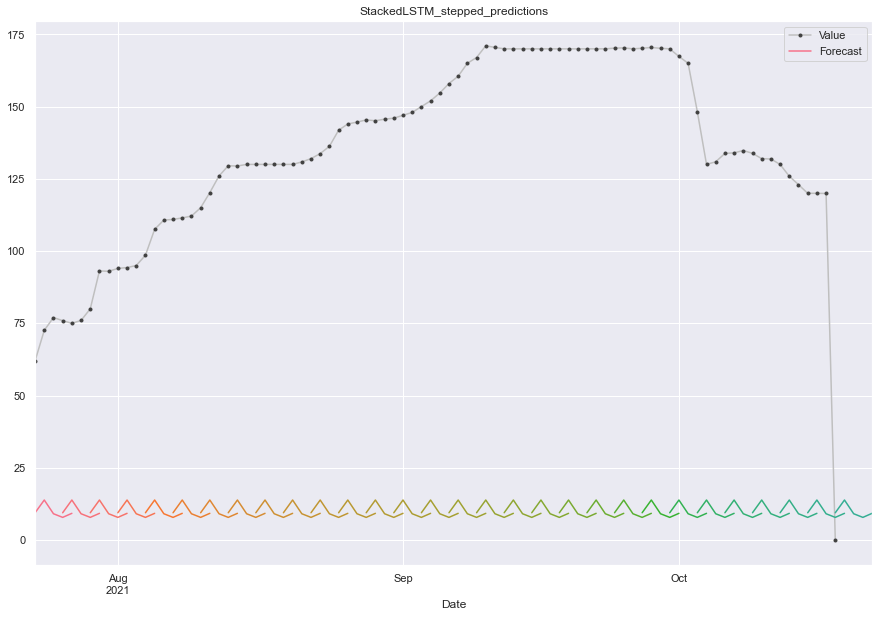

In [21]:
plot_stepped_predictions(model, X_val, y_val, 'StackedLSTM')

# Conclusion:
- Not great
- Cant capture anything
- Training result varies much on different training means that data is difficult and have many variance and stuffs
- Or maybe these models are not suitable